<a href="https://colab.research.google.com/github/marcio-lfo/devai/blob/main/Aprendizado_semi_supervisionado_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Importando a versão pré-pocessada do dataset mnist
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
# Utilizando apenas os 1400 primeiros exemplos para treino
X_train, y_train = X_digits[:1400], y_digits[:1400]
# Utilizando os demais para teste
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [52]:
# Utilizando um classificador de regressão logística
from sklearn.linear_model import LogisticRegression

# Utilizando apenas 50 y dos 1400
n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)

# Treinando a regressão logística
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [53]:
# Verificando qual é a capacidade de identificar os que estão no teste
log_reg.score(X_test, y_test)

0.7481108312342569

Esse é o resultado de apenas os 50 que não tem a representatividade dos demais.

In [54]:
# Verificando o score com o dataset completo, os 1400
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.906801007556675

Conclui-se que só utilizando os 1400 não conseguiremos atingir mais que 90% de acurácia.

Nós só temos os dígitos escaneados, vamos tentar extrair dessas figuras características, grupos que são importantes.

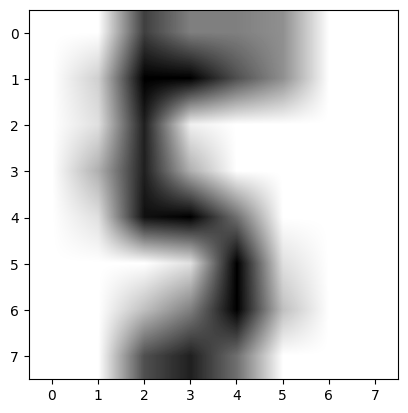

In [55]:
# Imprimindo um dígito da base
import matplotlib.pyplot as plt

plt.imshow(X_train[25].reshape(8,8), cmap='binary', interpolation="bilinear")
plt.show()

In [56]:
# Agrupando características
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
# Obtendo os índices mais representativos, mais próximo do centro
representative_digits_idx = X_digits_dist.argmin(axis=0)
# Obtendo os elementos
X_representative_digits = X_train[representative_digits_idx]

Quando coloca clusters a mais eles tendem a se comportar como agrupamento de agrupamento. É melhor ter mais clusters na prática do que de menos.

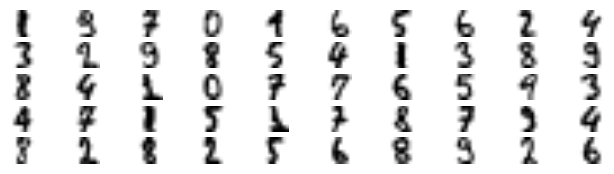

In [57]:
# Imprimindo os dígitos representativos
plt.figure(figsize=(8,2))
for index, X_representative_digit in enumerate(X_representative_digits):
  plt.subplot(k//10, 10, index+1)
  plt.imshow(X_representative_digit.reshape(8,8), cmap='binary', interpolation="bilinear")
  plt.axis("off")
plt.show()

In [58]:
# Criando o y representativo com o valor de cada figura
import numpy as np

y_representative_digits = np.array([
    1, 9, 7, 0, 1, 6, 5, 6, 2, 4,
    3, 2, 9, 8, 5, 4, 1, 3, 8, 9,
    8, 4, 1, 0, 7, 7, 6, 5, 9, 3,
    4, 7, 1, 5, 1, 7, 8, 7, 9, 4,
    8, 2, 8, 2, 5, 6, 8, 9, 2, 6
])

In [59]:
# Comparando com o representative index
y_representative_digits == y_train[representative_digits_idx]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Colocamos todos os valores corretamente.

In [60]:
# Treinamento com os 50 com boa representatividade
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8639798488664987

Observa-se que melhorou bastante o score escolhendo as amostras certas, de **74,8**% passou para **86,4**%.

Muitos dados nem sempre significa melhor qualidade, muitas vezes é melhor poucos dados que representam bem o que estamos fazendo.

In [61]:
# Propagando os dígitos para os clusters
# Cada amostra que foi atribuída a um cluster é atribuída a todos os exemplos que estão no cluster, semelhante ao KNN
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
  y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [62]:
# Verificando com o novo conjunto
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8765743073047859

Melhorou mas nem tanto.

In [63]:
# Propagando apenas para os que estão 95% mais próximos da fronteira, os que estão na borda serão ignorados
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  # Colocando um rótulo que não existe para desconsiderá-lo
  X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]
print(len(y_train_partially_propagated))

1309


In [64]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8816120906801007

Do propagado para o atual aumentou pouco, mas se compararmos o parcialmente propagado (**88,2**%) com o que não propagou nada (**86,4**%) deu uma grande diferença e, considerando que o total é **90%**, já estamos a 2% do limite teórico.

In [65]:
(y_train_partially_propagated == y_train[partially_propagated]).sum()

1256

In [66]:
# Calculando a média
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.959511077158136

Temos quase 5% de rótulos errados quando a gente propaga.
Perto do centro do cluster tem alguns que foram colocados no cluster errado, o que não faz muita diferença quando se propaga para mais.




# **Agrupamento com o algoritimo AgglomerativeClustering**

In [68]:
# Importando a versão pré-pocessada do dataset mnist
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
# Utilizando apenas os 1400 primeiros exemplos para treino
X_train, y_train = X_digits[:1400], y_digits[:1400]
# Utilizando os demais para teste
X_test, y_test = X_digits[1400:], y_digits[1400:]

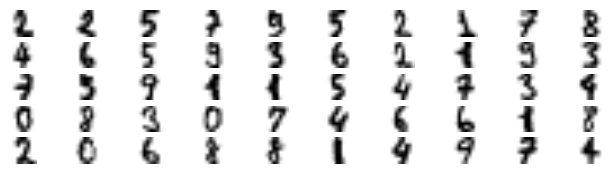

In [69]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

k = 50

# Utilizando o AgglomerativeClustering
agglomerative_clustering = AgglomerativeClustering(n_clusters=k)
X_digits_dist = agglomerative_clustering.fit_predict(X_train)

# Obtendo os índices mais representativos
representative_digits_idx = []
for cluster in range(k):
    cluster_indices = np.where(X_digits_dist == cluster)[0]
    representative_digits_idx.append(cluster_indices[np.argmin(X_digits_dist[cluster_indices])])

# Obtendo os elementos representativos
X_representative_digits = X_train[representative_digits_idx]

# Plotando os dígitos representativos
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation="bilinear")
    plt.axis("off")
plt.show()


In [70]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Utilizando o AgglomerativeClustering
n_clusters = 50
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
X_digits_labels = agg_clustering.fit_predict(X_train)

# Calculando as distâncias dos pontos ao centro do cluster
X_cluster_dist = np.zeros_like(X_digits_labels, dtype=float)
for cluster_label in np.unique(X_digits_labels):
    cluster_mask = (X_digits_labels == cluster_label)
    cluster_center = np.mean(X_train[cluster_mask], axis=0)
    distances = np.linalg.norm(X_train - cluster_center, axis=1)
    X_cluster_dist[cluster_mask] = distances[cluster_mask]

# Propagando rótulos até 95% mais próximos
percentile_closest = 95
for cluster_label in np.unique(X_digits_labels):
    cluster_mask = (X_digits_labels == cluster_label)
    cluster_dist = X_cluster_dist[cluster_mask]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)

    # Colocando um rótulo que não existe para desconsiderá-lo
    X_cluster_dist[cluster_mask & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]
print(len(y_train_partially_propagated))


1306


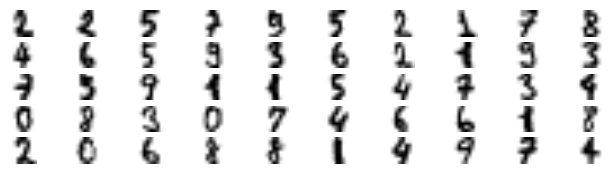

In [71]:
# Visualizando os exemplos representativos
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(n_clusters // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation="bilinear")
    plt.axis("off")
plt.show()

In [72]:
# Criando o y representativo com o valor de cada figura
import numpy as np

y_representative_digits = np.array([
    2, 2, 5, 7, 9, 5, 2, 1, 7, 8,
    4, 6, 5, 9, 3, 6, 2, 1, 9, 3,
    7, 5, 9, 1, 1, 5, 4, 7, 3, 4,
    0, 8, 3, 0, 7, 4, 6, 6, 1, 8,
    2, 0, 6, 8, 8, 1, 4, 9, 7, 4
])

In [73]:
# Comparando com o representative index
y_representative_digits == y_train[representative_digits_idx]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [74]:
# Treinamento com os 50 com boa representatividade
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8035264483627204

In [77]:
# Verificando o score parcial dos dados
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.906801007556675

In [76]:
# Verificando o score com o dataset completo, os 1400
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.906801007556675

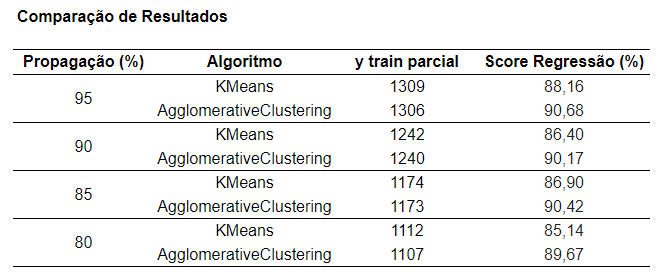

# **Tipo de Agrupamento:**

* **KMeans**: É um algoritmo de agrupamento particional, que atribui cada ponto de dados a um cluster com base na proximidade ao centroide mais próximo.

* **AgglomerativeClustering**: É um algoritmo de agrupamento hierárquico, que constrói uma árvore de clusters mesclando clusters adjacentes com base na similaridade.

# **Conclusão:**

Foi utilizado o algoritmo de agrupamento hierárquico aglomerativo, **AgglomerativeClustering**, implementado no scikit-learn em substituição ao KMeans.

Em todos os casos o algoritmo **AgglomerativeClustering** teve desempenho superior ao **KMeans**.

O aumento na porcentagem da propagação para **95%** proporcionou o aumento do score da regressão de forma que o score parcial dos dados se igualou ao score full das 1400 amostras, de **90,68%**.

